# SEM-EDS linescan plotting
- This notebook was written by C.L. Devitre (inspired by script from A. Bearden) and it shows how to plot linescans collected using SEM-EDS using ULTIMMAX detector from Oxford and Aztec software. It uses the images collected during acquisition to plot next to linescans. For this it requires that the image names contain the sample name as well. You should have renamed the images and linescans before exporting, or after exporting, or it won't work. 

## First install necessary packages

In [23]:
# %pip install imagecodecs
# %pip install Thermobar
# %pip install tifffile
# %pip install skimage

## Import dependencies

In [24]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from skimage import io
import Thermobar as pt
import tifffile
import xml.etree.ElementTree as ET
from tqdm import tqdm
import warnings
from scipy.signal import savgol_filter,find_peaks


## Set base working directory where your linescans and images are stored. 
- Note that images should be in their own "Images" folder. This can be done automatically when exporting from Aztec. 

In [25]:
base_directory = os.getcwd()
print(base_directory)

subfolder= 'LINESCANS_KAMI2_DevitreAll'
subdirectory= os.path.join(base_directory, subfolder)

print(subdirectory)

/Users/cljd/Documents/Python_dev/eds_linescan_processing
/Users/cljd/Documents/Python_dev/eds_linescan_processing/LINESCANS_KAMI2_DevitreAll


## Compile all linescans in the folder

In [26]:
data_dict = {}

def compile_linescans(folder):

    csv_files = [f for f in os.listdir(folder) if f.endswith('.csv')]

    image_folder=os.path.join(folder, 'Images') 
    image_files=os.listdir(image_folder)

    for file in tqdm(csv_files, desc="Compiling Linescans"):

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=FutureWarning)
            linescan = file
            name = linescan.split()[0]
            images_i = [img for img in image_files if name in img]

            data = pd.read_csv(os.path.join(subdirectory, linescan))
            data = data[data.columns.drop(list(data.filter(regex='Unnamed|Cl Ox%')))]

            data.rename(columns={
                'Mg Ox%': 'MgO',
                'Si Ox%': 'SiO2',
                'Ca Ox%': 'CaO',
                'Mn Ox%': 'MnO',
                'Fe Ox%': 'FeOt',
                'Ni Ox%': 'NiO',
                'Al Ox%': 'Al2O3',
                'Ti Ox%': 'TiO2',
                'Cr Ox%': 'Cr2O3',
                'S Ox%': 'SO3',
                'P Ox%': 'P2O5',
                'K Ox%': 'K2O',
                'Na Ox%': 'Na2O'
            }, inplace=True)

            data = pt.minClass(data)
            data['Mg#'] = 100 * (data['MgO'] / 40.304) / ((data['MgO'] / 40.304) + (data['FeOt'] / 71.844))

            data_dict[linescan] = {
                'linescan': linescan,
                'name':name,
                'data': data,
                'images_i': images_i
            }

    return image_folder, csv_files,image_files, data_dict

compiled_linescans=compile_linescans(subdirectory)


# compiled_linescans[3] # This shows you "data_dict"

Compiling Linescans: 100%|██████████| 9/9 [00:00<00:00, 25.06it/s]


## Next clean up the phases and save plot. 
- This is useful for glasses for example, that are misidentified by mineralML as amphibole. It uses mineralML to ID the phases present in the linescan, and then based on the prediction threshold, it reassigns the phase as glass etc. The predicition threshold is set with probability_filter (by default 0.97). 
- By default does not display plot to save time, but it saves it.

In [27]:
def plot_phase_ID_cleanup(subdirectory,image_folder,image_files,data_dict, csv_files,probability_filter=0.97,display_fig=False):

    for file in tqdm(csv_files, desc="Plot Cleanup ID"):

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=FutureWarning)

            name=data_dict[file]['name']
            images_i=[img for img in image_files if name in img]
            data = data_dict[file]['data']

            ## This ensures that spots misidentified as low confidence minerals (which are actually glass and the interfaces), are correctly IDed in a new column

            data.loc[~(data['Predict_Probability']>probability_filter),'Phase_type']='Glass'
            data.loc[(data['Predict_Probability']>probability_filter),'Phase_type']=data['Predict_Mineral']
            data.insert(2,'Phase_type',data.pop('Phase_type'))

            ###### This lets you look at the phases originally IDed and the confidence of prediction
            fig, ax = plt.subplots(2, 3, figsize=(15, 7))
            col = 'Predict_Mineral'
            filt_col='Phase_type'

            x_col='Distance (µm)'
            y_col_ax0='MgO'
            y_col_ax1='Predict_Probability'

            colors = plt.cm.tab10.colors
            mineral_list = list(data[col].unique())
            color_map = {mineral: colors[i % len(colors)] for i, mineral in enumerate(mineral_list)}
            color_map['Glass']='grey'

            ### First, the output predicted from mineral ML
            for mineral in mineral_list:

                mask_low_conf = (data[col] == mineral) & ~(data[y_col_ax1] > probability_filter)
                mask_high_conf = (data[col] == mineral) & (data[y_col_ax1] > probability_filter)
                
                ax[0,0].scatter(data[x_col][mask_low_conf], data[y_col_ax0][mask_low_conf],
                            label=mineral, edgecolor='k', linewidths=0.5, color=color_map[mineral])
                ax[0,0].scatter(data[x_col][mask_high_conf], data[y_col_ax0][mask_high_conf],
                            marker='*', s=90, edgecolor='k', linewidths=0.5, color=color_map[mineral])

                ax[1,0].scatter(data[x_col][mask_low_conf], data[y_col_ax1][mask_low_conf],
                            label=mineral, edgecolor='k', linewidths=0.5,color=color_map[mineral])
                ax[1,0].scatter(data[x_col][mask_high_conf], data[y_col_ax1][mask_high_conf],
                            marker='*', s=90, edgecolor='k', linewidths=0.5,color=color_map[mineral])

            ### Next, we plot the filtered output (reassigned phases based on confidence of prediction)
            mineral_list_filt= list(data[filt_col].unique())

            for mineral in mineral_list_filt:

                mask_low_conf = (data[filt_col] == mineral) & ~(data[y_col_ax1] > probability_filter)
                mask_high_conf = (data[filt_col] == mineral) & (data[y_col_ax1] > probability_filter)
                
                ax[0,1].scatter(data[x_col][mask_low_conf], data[y_col_ax0][mask_low_conf],
                            label=mineral, edgecolor='k', linewidths=0.5, color=color_map[mineral])
                ax[0,1].scatter(data[x_col][mask_high_conf], data[y_col_ax0][mask_high_conf],
                            marker='*', s=90, edgecolor='k', linewidths=0.5, color=color_map[mineral])

                ax[1,1].scatter(data[x_col][mask_low_conf], data[y_col_ax1][mask_low_conf],
                            label=mineral, edgecolor='k', linewidths=0.5,color=color_map[mineral])
                ax[1,1].scatter(data[x_col][mask_high_conf], data[y_col_ax1][mask_high_conf],
                            marker='*', s=90, edgecolor='k', linewidths=0.5,color=color_map[mineral])
            ax[0,0].set_ylabel(y_col_ax0+' (wt%)')
            ax[1,0].set_ylabel(y_col_ax1)

            for i, j in [(0,0), (0,1), (1,0), (1,1)]:
                axes = ax[i, j]
                axes.scatter(None, None, marker='*', color='white', edgecolor='k', s=90, linewidths=0.5, label='Probability >'+str(probability_filter))
                if (i, j) in [(0,0),(1,0)]:
                    axes.legend(title=col, loc='best')
                else:
                    axes.legend(title=filt_col, loc='best')       
                axes.set_xlabel(x_col)

            def plot_tiff_image(ax_i, pattern, pos):
                img_name = [img for img in images_i if pattern in img][0]
                with tifffile.TiffFile(os.path.join(image_folder, img_name)) as tif:
                    desc = tif.pages[0].tags['ImageDescription'].value
                root = ET.fromstring(desc)
                w = float(root.findtext('ImageWidth_um'))
                h = float(root.findtext('ImageHeight_um'))
                img = io.imread(os.path.join(image_folder, img_name))
                ax_i[pos].imshow(img, extent=[0, w, h, 0], origin='lower')
                ax_i[pos].set_xlim(0, w)
                ax_i[pos].set_ylim(0, h)
                ax_i[pos].set_xlabel('Width (µm)')
                ax_i[pos].set_ylabel('Height (µm)')

            plot_tiff_image(ax, '(SE)', (0, 2))
            plot_tiff_image(ax, '(BSE)', (1, 2))

            fig.tight_layout()

            plots_folder=os.path.join(subdirectory,'Notebook_plots')
            if os.path.exists(plots_folder)==False:
                os.makedirs(plots_folder)
                
            fig.savefig(os.path.join(plots_folder,name+'_Phase_ID_cleanup.png'))
            if display_fig==False:
                plt.close(fig)


plot_phase_ID_cleanup(subdirectory=subdirectory,image_folder=compiled_linescans[0],
                      csv_files=compiled_linescans[1],image_files=compiled_linescans[2],data_dict=compiled_linescans[3], 
                      probability_filter=0.97,display_fig=False)

Plot Cleanup ID: 100%|██████████| 9/9 [00:03<00:00,  2.73it/s]


## Now plot a linescan and an element

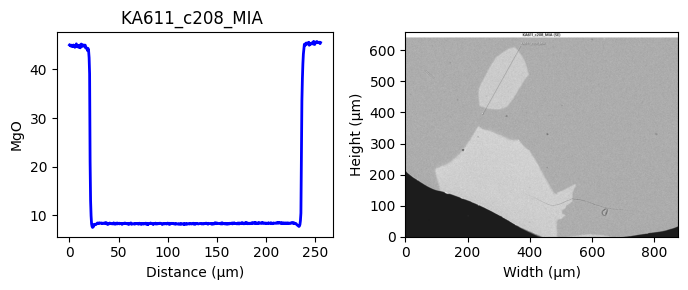

In [28]:
element='MgO' # pick an element to show
linescan_number=5 # Pick a linescan

selected_linescan=compiled_linescans[1][linescan_number]
plot_df=compiled_linescans[3][selected_linescan]['data']

fig,ax=plt.subplots(1,2,figsize=(7,3))
ax[0].plot(plot_df['Distance (µm)'], plot_df[element], color='b', linewidth=2)
ax[0].set_title(selected_linescan.split("-")[0])
ax[0].set_xlabel('Distance (µm)')
ax[0].set_ylabel(element)


img_name = [img for img in compiled_linescans[2] if selected_linescan.split("-")[0] in img and '(SE)' in img][0]

with tifffile.TiffFile(os.path.join(compiled_linescans[0], img_name)) as tif:
    desc = tif.pages[0].tags['ImageDescription'].value
root = ET.fromstring(desc)
w = float(root.findtext('ImageWidth_um'))
h = float(root.findtext('ImageHeight_um'))
img = io.imread(os.path.join(compiled_linescans[0], img_name))

ax[1].imshow(img, extent=[0, w, h, 0], origin='lower')
ax[1].set_xlim(0, w)
ax[1].set_ylim(0, h)
ax[1].set_xlabel('Width (µm)')
ax[1].set_ylabel('Height (µm)')

plt.tight_layout()



## Now find inflections in the linescan (to plot only region inside)
- Uses derivative and zero-crossings to ID inflection points and plot only inside the inflections

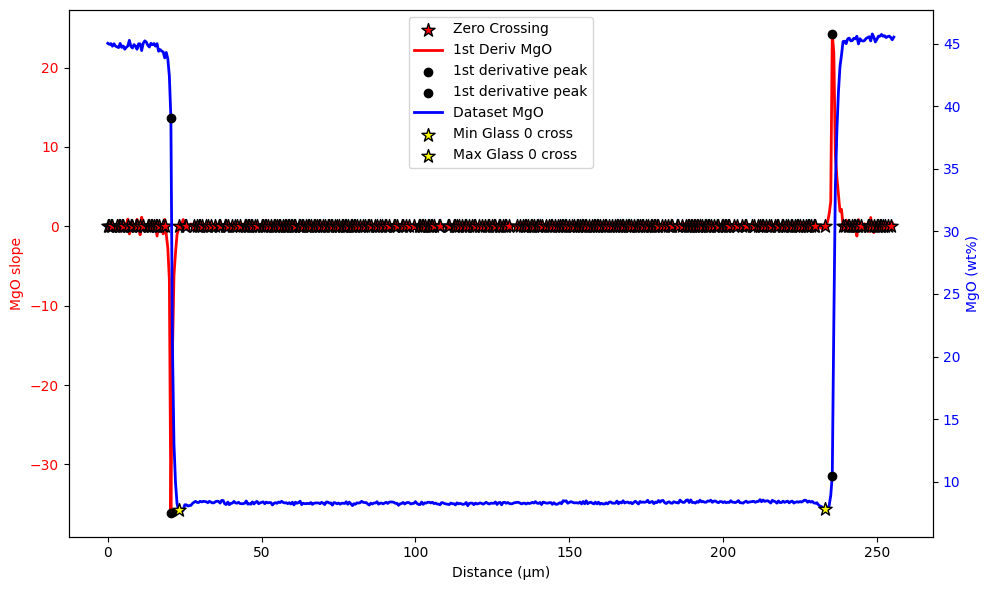

In [29]:
x = plot_df['Distance (µm)']
y = plot_df[element]
y_smooth = savgol_filter(y, window_length=5, polyorder=2)

m = np.diff(y) / np.diff(x)
m_smooth = np.diff(y_smooth) / np.diff(x)

min_peak_height=5
positive_peaks, _ = find_peaks(m,height=min_peak_height)
negative_peaks, _ = find_peaks(-m,height=min_peak_height)

zero_cross_m=m.copy()

zero_cross_mask = np.zeros_like(zero_cross_m, dtype=bool)
for i in range(len(zero_cross_m) - 1):
    if np.sign(zero_cross_m[i]) != np.sign(zero_cross_m[i + 1]):
        zero_cross_mask[i] = True
        
zero_cross_x = x[:-1][zero_cross_mask] 
zero_cross_y = y[:-1][zero_cross_mask] 

### Make a subset dataframe with only the glass in between the zero crossings
min_zerocrossing_glass=plot_df[:-1][(zero_cross_mask) & (plot_df[:-1]['Predict_Mineral'] != 'Olivine')]['Distance (µm)'].idxmin()
max_zerocrossing_glass=plot_df[:-1][(zero_cross_mask) & (plot_df[:-1]['Predict_Mineral'] != 'Olivine')]['Distance (µm)'].idxmax()

subset_df = plot_df[(plot_df['Distance (µm)'] >= plot_df.iloc[min_zerocrossing_glass]['Distance (µm)']) & 
                    (plot_df['Distance (µm)'] <= plot_df.iloc[max_zerocrossing_glass]['Distance (µm)'])]

######### Now plot for tweaking 
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.scatter(zero_cross_x, np.zeros_like(zero_cross_x), marker='*',edgecolors='k',color='r', s=100, zorder=5, label="Zero Crossing")

ax1.plot(x[:-1], m, label=f'1st Deriv {element}', color='r', linestyle='-', linewidth=2)

ax1.set_xlabel('Distance (µm)')
ax1.set_ylabel(f'{element} slope', color='r')
ax1.tick_params(axis='y', labelcolor='r')

ax2 = ax1.twinx()
ax2.plot(x, y, label=f'Dataset {element}', color='b', linewidth=2)
ax2.scatter(x[positive_peaks], y[positive_peaks], color='k', edgecolors='k', zorder=5)
ax2.scatter(x[negative_peaks], y[negative_peaks], color='k',edgecolors='k', zorder=5)
ax1.scatter(x[positive_peaks], m[positive_peaks], color='k', edgecolors='k',label='1st derivative peak', zorder=5)
ax1.scatter(x[negative_peaks], m[negative_peaks], color='k', edgecolors='k', label='1st derivative peak', zorder=5)

ax2.scatter(plot_df.iloc[min_zerocrossing_glass]['Distance (µm)'], plot_df.iloc[min_zerocrossing_glass]['MgO'], marker='*',edgecolors='k',color='yellow', s=100, zorder=5, label="Min Glass 0 cross")
ax2.scatter(plot_df.iloc[max_zerocrossing_glass]['Distance (µm)'], plot_df.iloc[max_zerocrossing_glass]['MgO'], marker='*',edgecolors='k',color='yellow', s=100, zorder=5, label="Max Glass 0 cross")

ax2.set_ylabel(f'{element} (wt%)', color='b')
ax2.tick_params(axis='y', labelcolor='b')

handles, labels = [], []
for ax in [ax1, ax2]:
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

# Add a combined legend
ax1.legend(handles=handles, labels=labels, loc='upper center')

plt.tight_layout()
plt.show()


## Plot two elements for a linescan to check
- Note: right now, the errorbars are manually set in the errorbar call based on calculations. You'd have to adjust to what you think your error is...

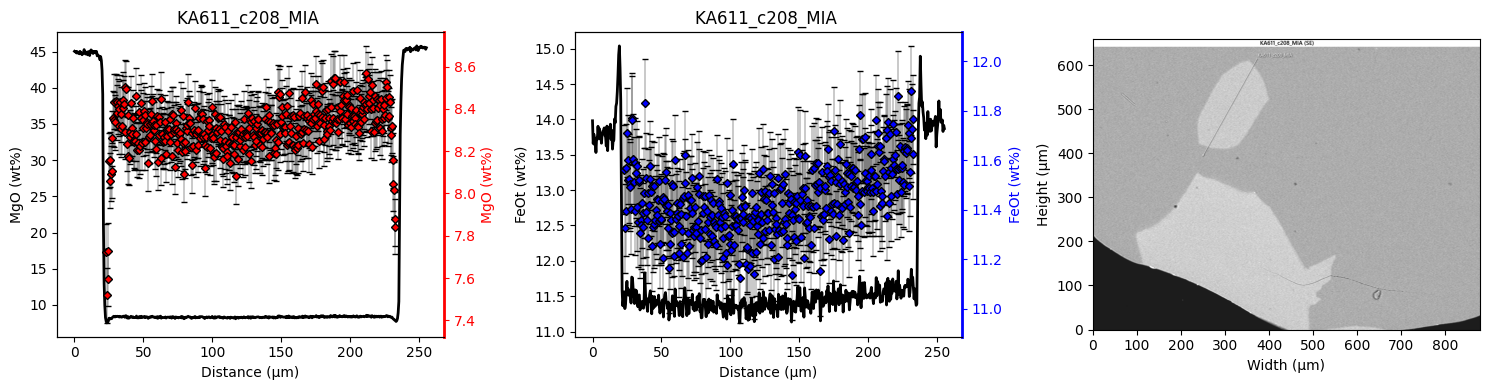

In [30]:
element1='MgO'
element2='FeOt'
yerr1=0.13
yerr2=0.18

fig,ax=plt.subplots(1,3,figsize=(15,4))

ax[0].plot(plot_df['Distance (µm)'], plot_df[element1], color='k', linewidth=2)
ax[0].set_title(selected_linescan.split("-")[0])
ax[0].set_xlabel('Distance (µm)')
ax[0].set_ylabel(f'{element1} (wt%)')

ax2 = ax[0].twinx()

ax2.errorbar(x=subset_df['Distance (µm)'], y=subset_df[element1], yerr=yerr1, linestyle='none', capsize=2, ecolor='k',mec='k',elinewidth=0.3,markersize=4, fmt='D', color='r')
ax2.set_ylabel(f'{element1} (wt%)', color='r')
ax2.tick_params(axis='y', labelcolor='r',colors='r')
ax2.spines['right'].set_color('r')
ax2.spines['right'].set_linewidth(2)


ax[1].plot(plot_df['Distance (µm)'], plot_df[element2], color='k', linewidth=2)
ax[1].set_title(selected_linescan.split("-")[0])
ax[1].set_xlabel('Distance (µm)')
ax[1].set_ylabel(f'{element2} (wt%)')

ax3 = ax[1].twinx()

ax3.errorbar(x=subset_df['Distance (µm)'], y=subset_df[element2], yerr=yerr2, linestyle='none', capsize=2, ecolor='k',mec='k',elinewidth=0.3,markersize=4, fmt='D', color='b')
ax3.set_ylabel(f'{element2} (wt%)', color='b')
ax3.tick_params(axis='y', labelcolor='b',colors='b')
ax3.spines['right'].set_color('b')
ax3.spines['right'].set_linewidth(2)

img_name = [img for img in compiled_linescans[2] if selected_linescan.split("-")[0] in img and '(SE)' in img][0]

with tifffile.TiffFile(os.path.join(compiled_linescans[0], img_name)) as tif:
    desc = tif.pages[0].tags['ImageDescription'].value
root = ET.fromstring(desc)
w = float(root.findtext('ImageWidth_um'))
h = float(root.findtext('ImageHeight_um'))
img = io.imread(os.path.join(compiled_linescans[0], img_name))

ax[2].imshow(img, extent=[0, w, h, 0], origin='lower')
ax[2].set_xlim(0, w)
ax[2].set_ylim(0, h)
ax[2].set_xlabel('Width (µm)')
ax[2].set_ylabel('Height (µm)')



plt.tight_layout()

plots_folder=os.path.join(subdirectory,'Notebook_plots')
if os.path.exists(plots_folder)==False:
    os.makedirs(plots_folder)
    
fig.savefig(os.path.join(plots_folder,selected_linescan.split("-")[0]+'_newplots_Glass.png'))


## Import the standard data to calculate uncertainties if available
- Note: right now this isn't being automatically updated in the plots below

In [31]:
standards=pd.read_excel("Standards_with_recoveries.xlsx")

cond1=standards['Standard'].str.contains('JDF|KL2|VG2|A99|ML3')
cond2=standards['Livetime(s)']==6

elements_list_2plot = ['MgO', 'FeOt', 'Al2O3', 'SiO2', 'TiO2', 'CaO', 'Na2O', 'K2O', 'MnO', 'SO3']

mean_sig_dict = {}
for element in elements_list_2plot:
    col_name = f'Oxide % Sigma_{element}'
    mean_sig_dict[element] = standards[(cond1) & (cond2)][col_name].mean()

mean_sig_dict



{'MgO': 0.0885888888888889,
 'FeOt': 0.12706296296296296,
 'Al2O3': 0.1164037037037037,
 'SiO2': 0.2121259259259259,
 'TiO2': 0.06732962962962963,
 'CaO': 0.0841962962962963,
 'Na2O': 0.07533333333333332,
 'K2O': 0.03133333333333333,
 'MnO': 0.05017777777777778,
 'SO3': 0.06013333333333334}

## Now loop and save plots for element pairs 
- Note: this can only plot element pairs, so you have to manually adjust element1 and element2. WARNING: element actually is used to calculate the inflections, so I don't recommend changing it unless you are certain another element will give you better results based on past couple of steps. MgO tends to perform well. 
- Note 2: right now the errorbars are being set as 2X the mean sigma from the standards above. 

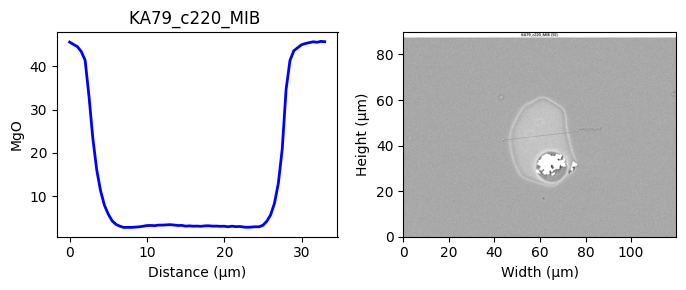

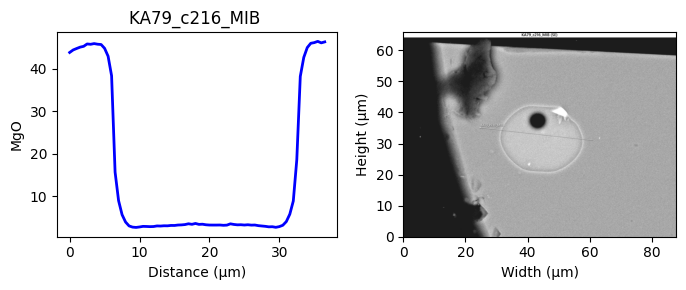

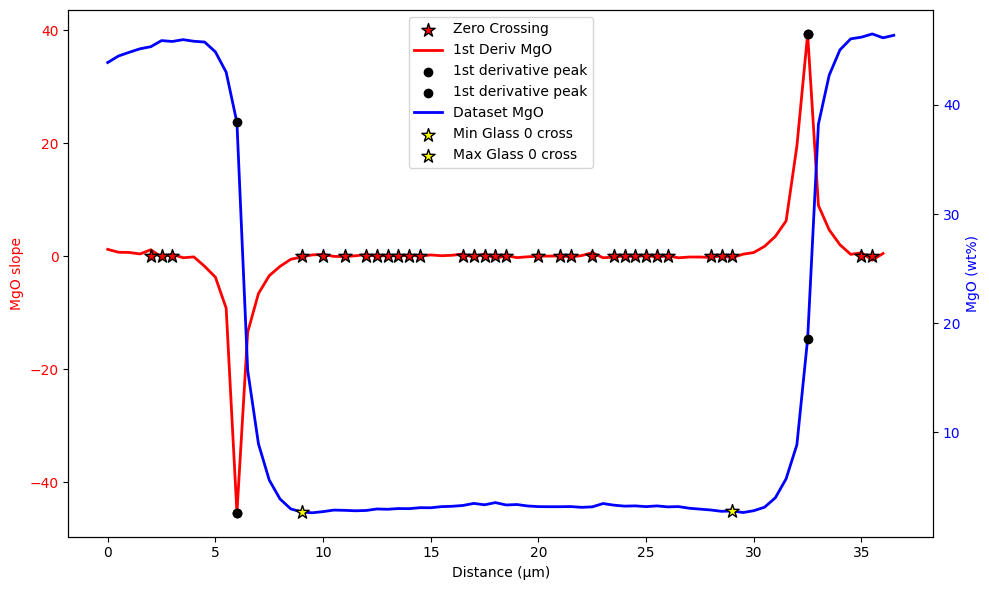

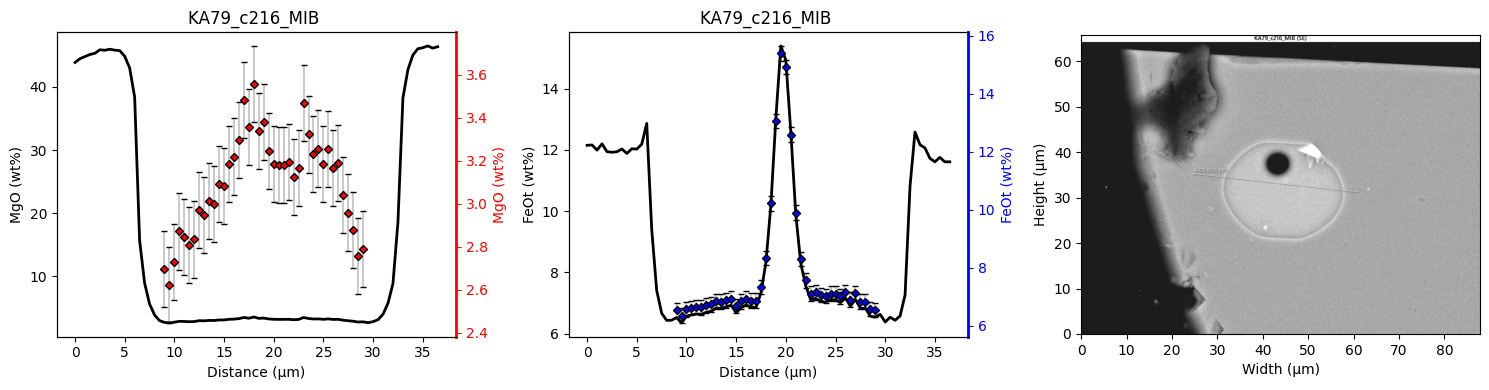

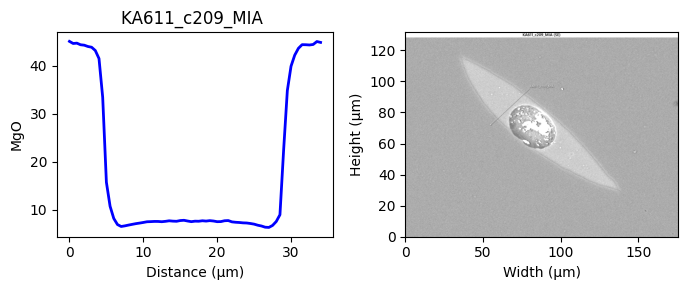

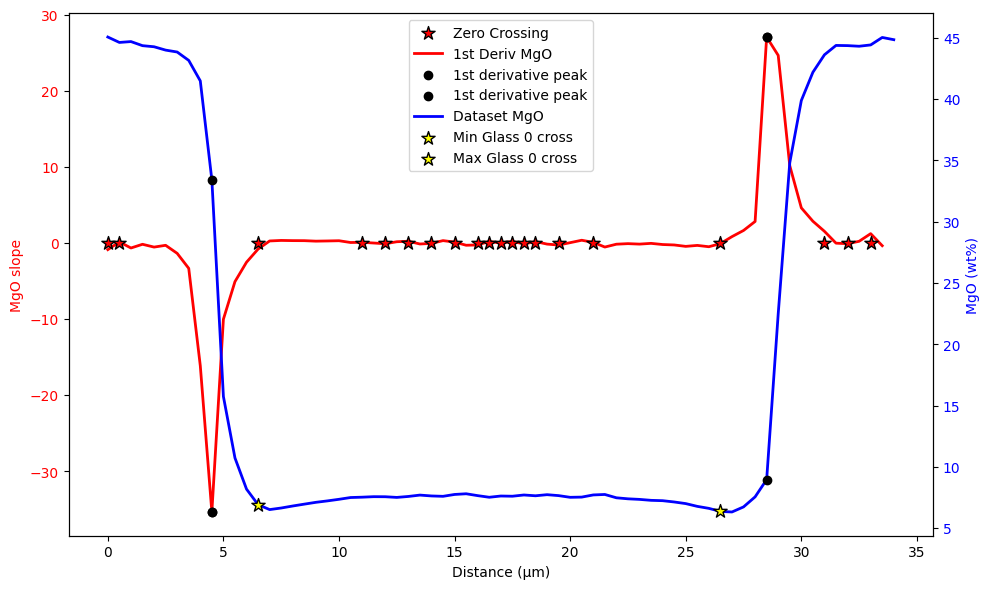

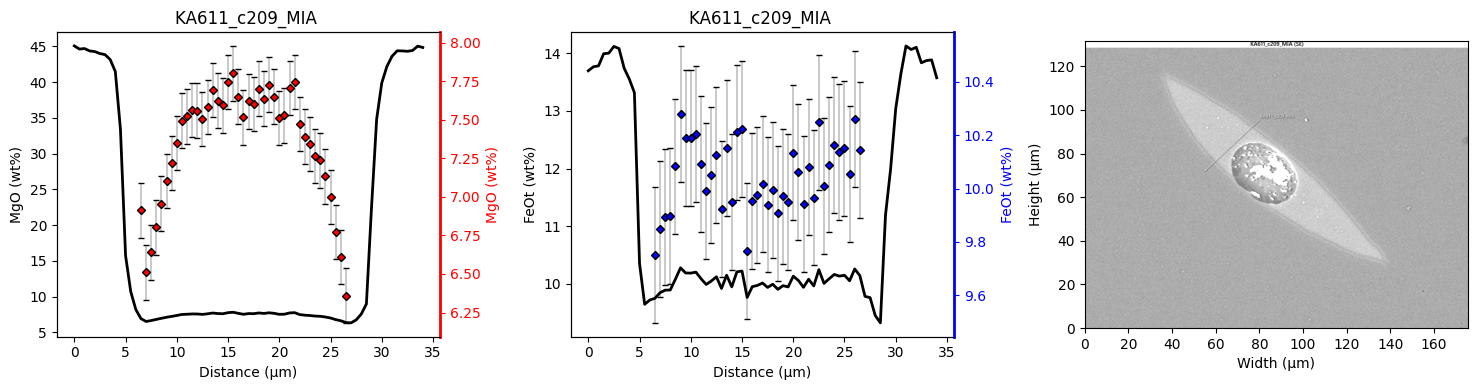

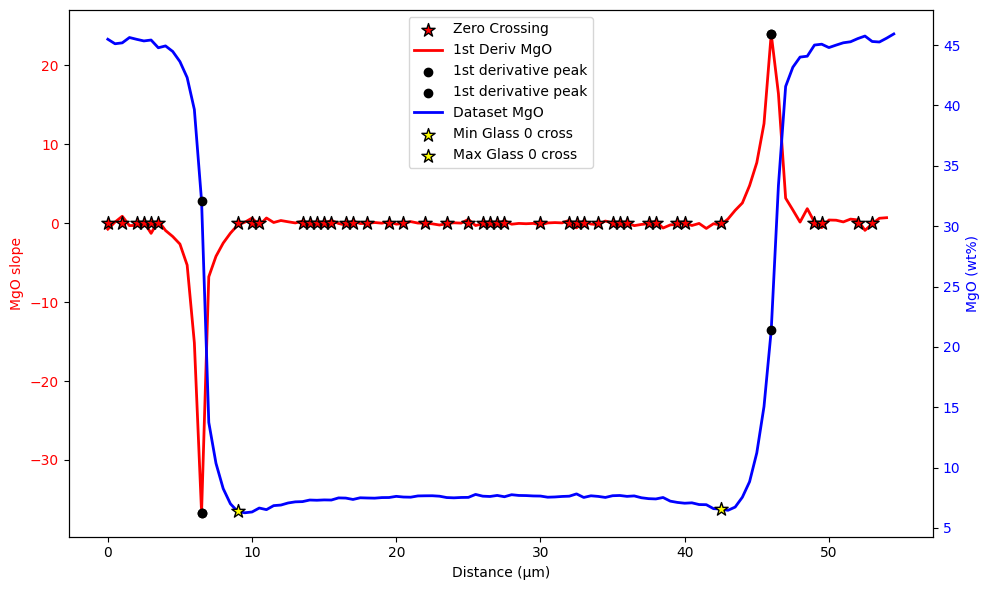

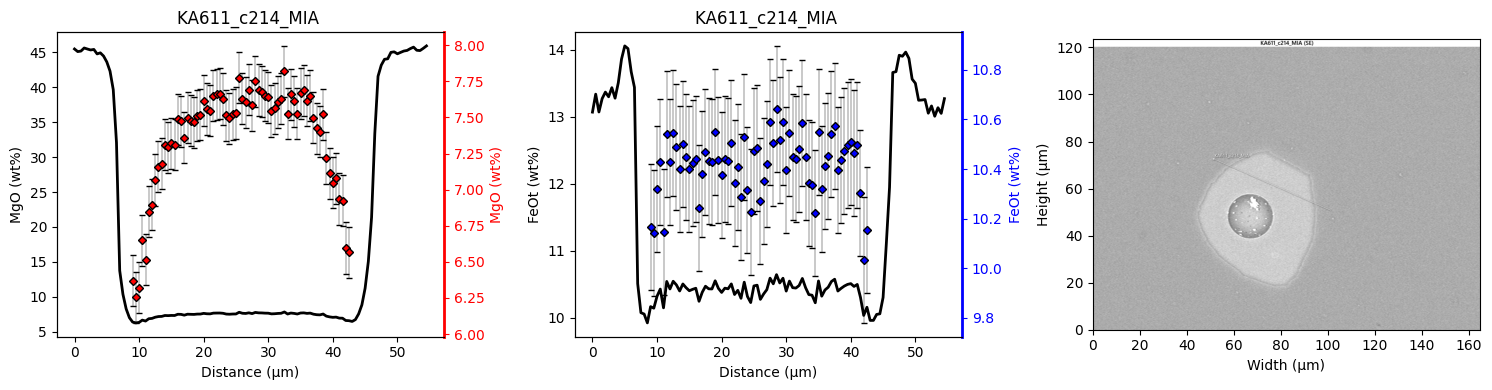

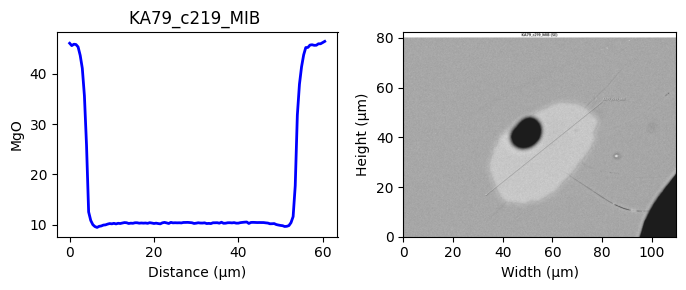

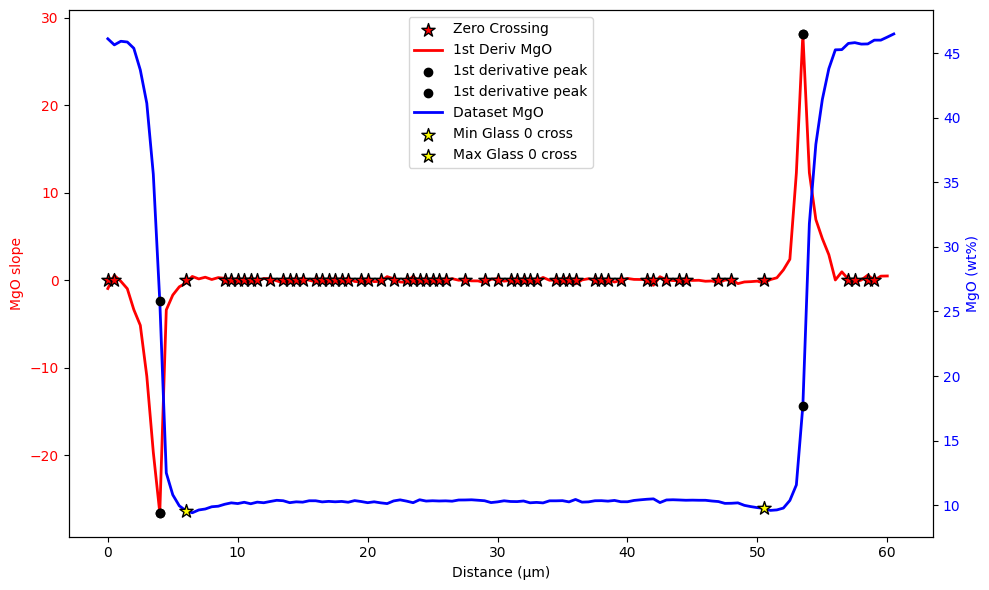

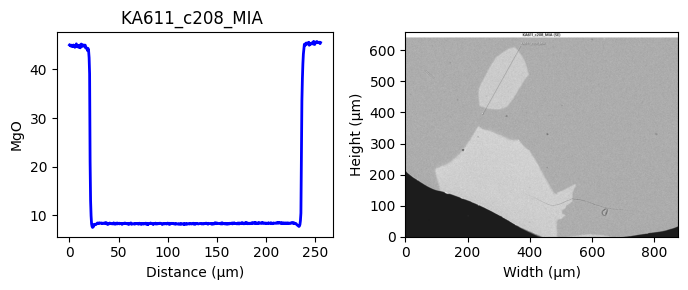

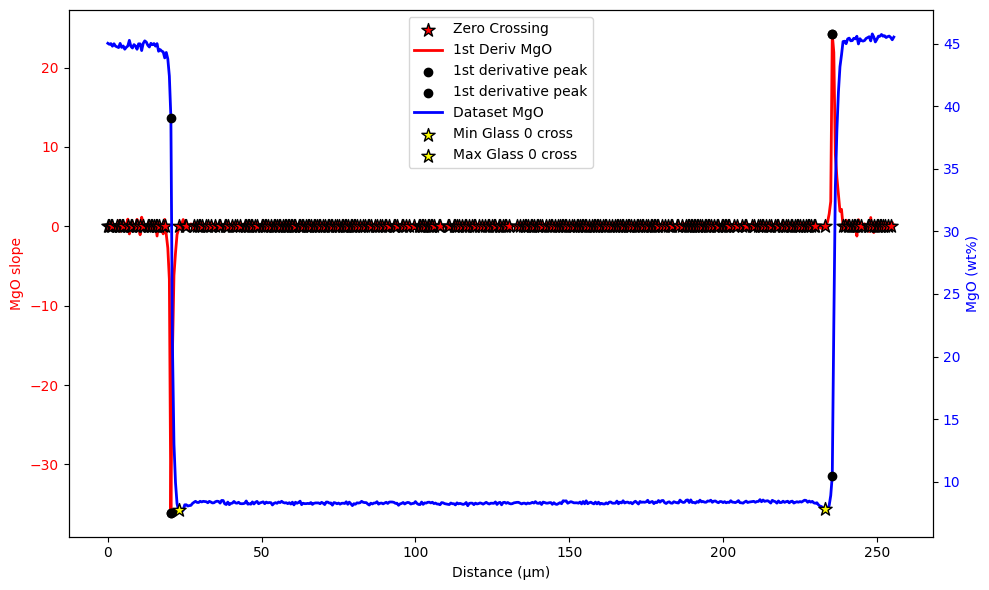

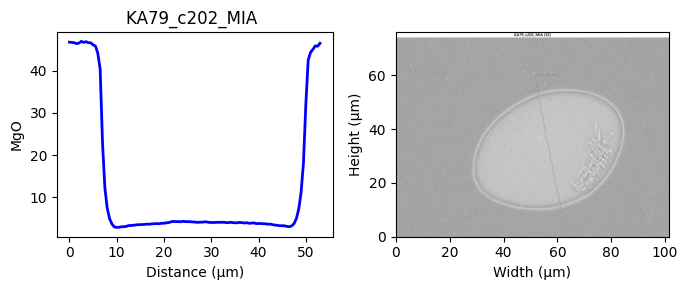

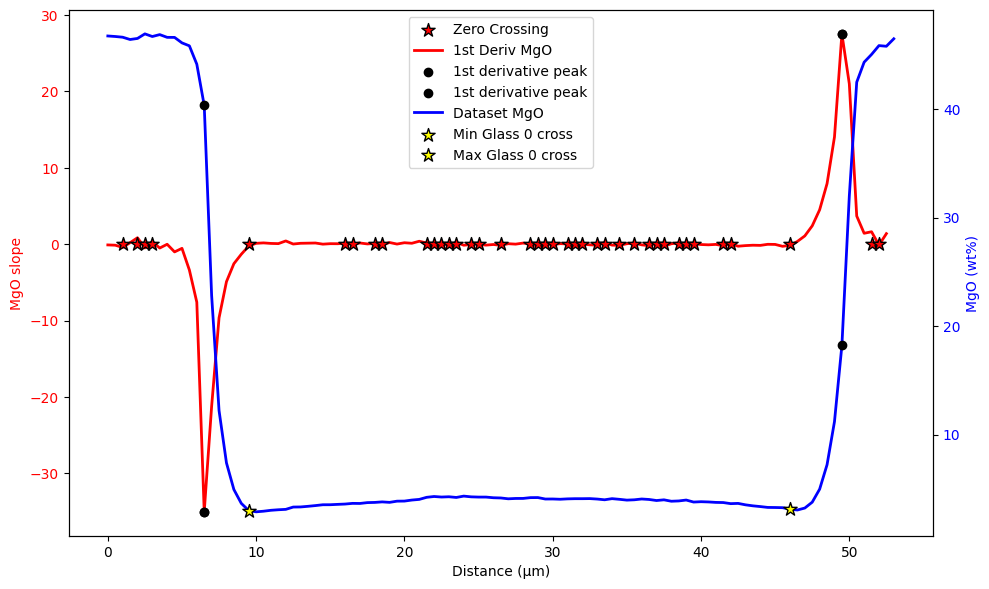

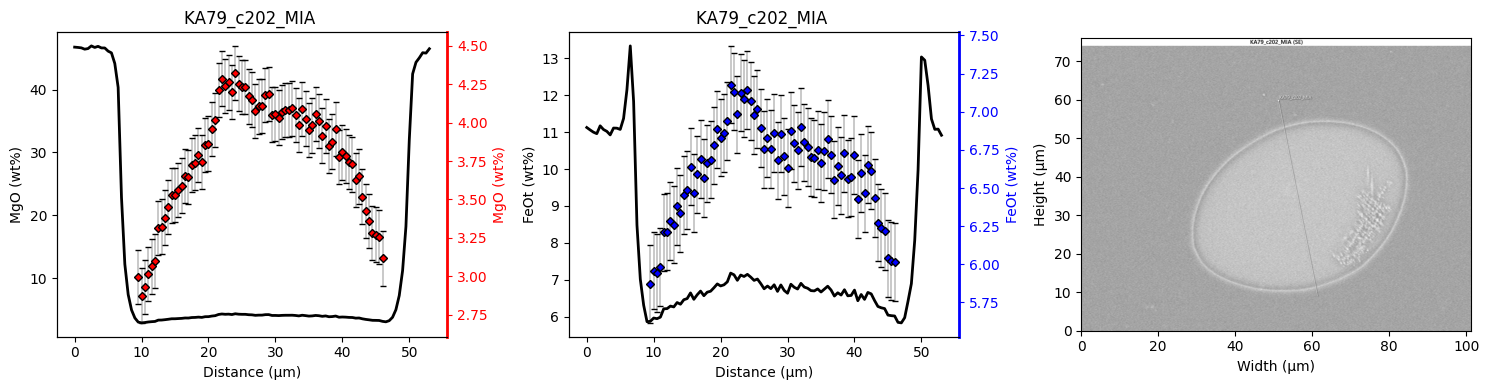

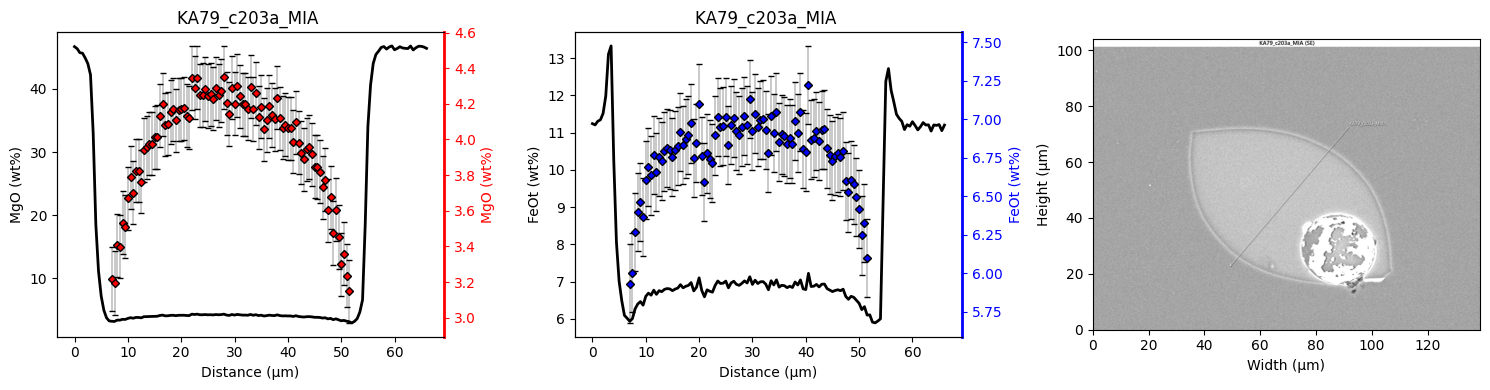

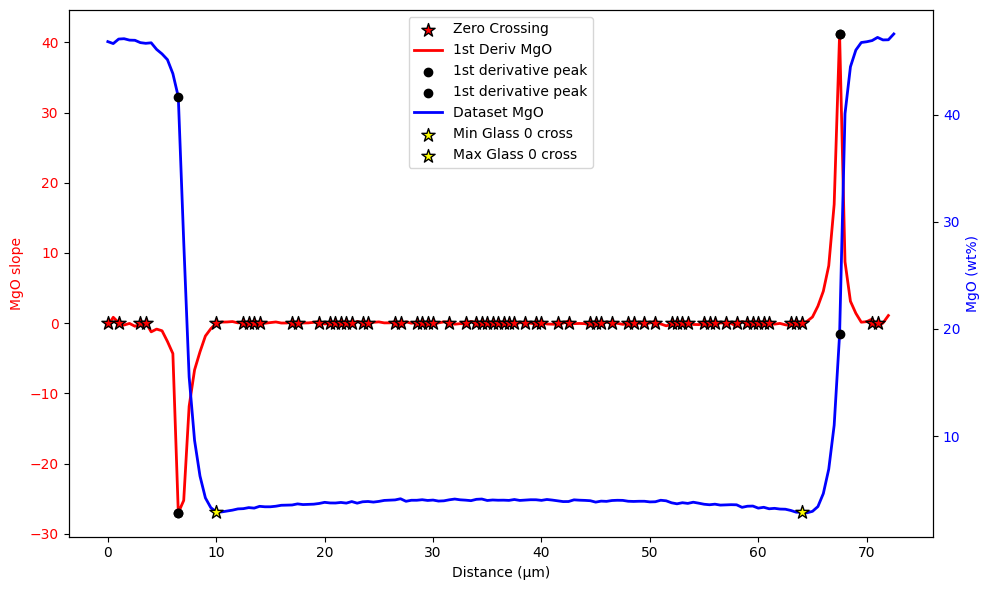

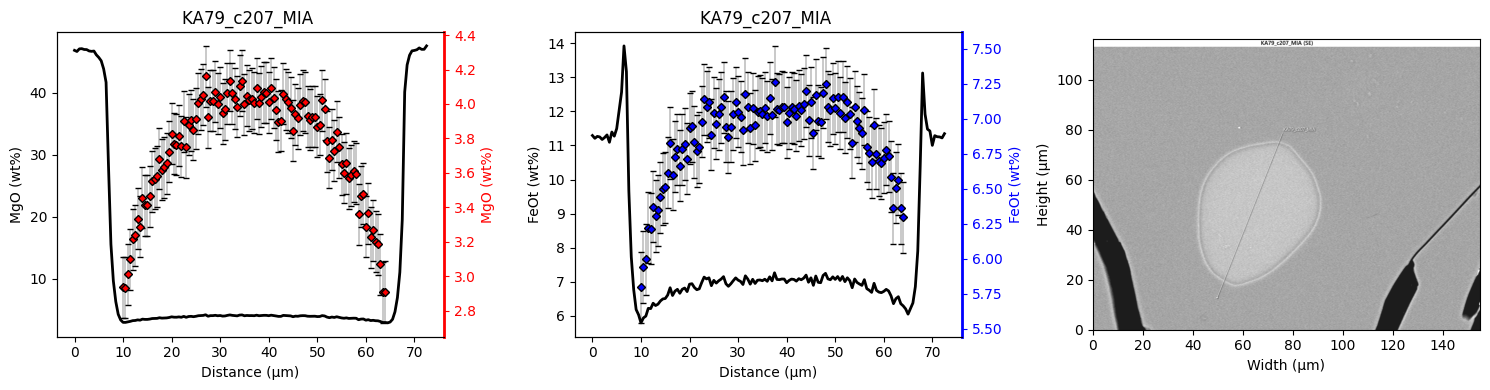

In [32]:
element='MgO'
element1 = 'MgO'
element2 = 'FeOt'
yerr1=2*mean_sig_dict[element1]
yerr2=2*mean_sig_dict[element2]

linescan_numbers = range(0, len(compiled_linescans[1]))  # Loop through linescan numbers (adjust as needed)

for linescan_number in linescan_numbers:
    selected_linescan = compiled_linescans[1][linescan_number]
    plot_df = compiled_linescans[3][selected_linescan]['data']

    fig, ax = plt.subplots(1, 2, figsize=(7, 3))
    ax[0].plot(plot_df['Distance (µm)'], plot_df[element], color='b', linewidth=2)
    ax[0].set_title(selected_linescan.split("-")[0])
    ax[0].set_xlabel('Distance (µm)')
    ax[0].set_ylabel(element)

    img_name = [img for img in compiled_linescans[2] if selected_linescan.split("-")[0] in img and '(SE)' in img][0]

    with tifffile.TiffFile(os.path.join(compiled_linescans[0], img_name)) as tif:
        desc = tif.pages[0].tags['ImageDescription'].value
    root = ET.fromstring(desc)
    w = float(root.findtext('ImageWidth_um'))
    h = float(root.findtext('ImageHeight_um'))
    img = io.imread(os.path.join(compiled_linescans[0], img_name))

    ax[1].imshow(img, extent=[0, w, h, 0], origin='lower')
    ax[1].set_xlim(0, w)
    ax[1].set_ylim(0, h)
    ax[1].set_xlabel('Width (µm)')
    ax[1].set_ylabel('Height (µm)')

    plt.tight_layout()

    x = plot_df['Distance (µm)']
    y = plot_df[element]
    y_smooth = savgol_filter(y, window_length=5, polyorder=2)

    m = np.diff(y) / np.diff(x)
    m_smooth = np.diff(y_smooth) / np.diff(x)

    min_peak_height = 5
    positive_peaks, _ = find_peaks(m, height=min_peak_height)
    negative_peaks, _ = find_peaks(-m, height=min_peak_height)
    peaks=np.concatenate((positive_peaks,negative_peaks))

    zero_cross_m = m.copy()

    zero_cross_mask = np.zeros_like(zero_cross_m, dtype=bool)
    for i in range(len(zero_cross_m) - 1):
        if np.sign(zero_cross_m[i]) != np.sign(zero_cross_m[i + 1]):
            zero_cross_mask[i] = True

    zero_cross_x = x[:-1][zero_cross_mask]
    zero_cross_y = y[:-1][zero_cross_mask]

    try:
        min_zerocrossing_glass = plot_df[:-1][(zero_cross_mask) & (plot_df[:-1]['Predict_Mineral'] != 'Olivine')]['Distance (µm)'].idxmin()
        max_zerocrossing_glass = plot_df[:-1][(zero_cross_mask) & (plot_df[:-1]['Predict_Mineral'] != 'Olivine')]['Distance (µm)'].idxmax()

        if plot_df.iloc[max_zerocrossing_glass]['Distance (µm)']-plot_df.iloc[min_zerocrossing_glass]['Distance (µm)'] >= 3:
            subset_df = plot_df[(plot_df['Distance (µm)'] >= plot_df.iloc[min_zerocrossing_glass]['Distance (µm)']) & 
                                (plot_df['Distance (µm)'] <= plot_df.iloc[max_zerocrossing_glass]['Distance (µm)'])]
            exception=False
        else:
            try:
                subset_df = plot_df[(plot_df['Distance (µm)'] >= plot_df.iloc[min(peaks)]['Distance (µm)']) & 
                                    (plot_df['Distance (µm)'] <= plot_df.iloc[max(peaks)]['Distance (µm)'])]
                exception=True
            except Exception as e:
                print(f"Error: {e}")
                subset_df = plot_df[~(plot_df['Predict_Mineral']=='Olivine')&~(plot_df['MgO']>20)].copy()
                exception=True

    except Exception as e:
        print(f"Error: {e}")
        subset_df = plot_df[~(plot_df['Predict_Mineral']=='Olivine')&~(plot_df['MgO']>20)].copy()
        exception=True

    ######### Now plot for tweaking 
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.scatter(zero_cross_x, np.zeros_like(zero_cross_x), marker='*', edgecolors='k', color='r', s=100, zorder=5, label="Zero Crossing")

    ax1.plot(x[:-1], m, label=f'1st Deriv {element}', color='r', linestyle='-', linewidth=2)

    ax1.set_xlabel('Distance (µm)')
    ax1.set_ylabel(f'{element} slope', color='r')
    ax1.tick_params(axis='y', labelcolor='r')

    ax2 = ax1.twinx()
    ax2.plot(x, y, label=f'Dataset {element}', color='b', linewidth=2)
    ax2.scatter(x[peaks], y[peaks], color='k', edgecolors='k', zorder=5)
    ax1.scatter(x[peaks], m[peaks], color='k', edgecolors='k', label='1st derivative peak', zorder=5)
    ax1.scatter(x[peaks], m[peaks], color='k', edgecolors='k', label='1st derivative peak', zorder=5)
    
    if exception==False:
        ax2.scatter(plot_df.iloc[min_zerocrossing_glass]['Distance (µm)'], plot_df.iloc[min_zerocrossing_glass]['MgO'], marker='*', edgecolors='k', color='yellow', s=100, zorder=5, label="Min Glass 0 cross")
        ax2.scatter(plot_df.iloc[max_zerocrossing_glass]['Distance (µm)'], plot_df.iloc[max_zerocrossing_glass]['MgO'], marker='*', edgecolors='k', color='yellow', s=100, zorder=5, label="Max Glass 0 cross")

    ax2.set_ylabel(f'{element} (wt%)', color='b')
    ax2.tick_params(axis='y', labelcolor='b')

    handles, labels = [], []
    for ax in [ax1, ax2]:
        h, l = ax.get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)

    # Add a combined legend
    ax1.legend(handles=handles, labels=labels, loc='upper center')

    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(1, 3, figsize=(15, 4))

    ax[0].plot(plot_df['Distance (µm)'], plot_df[element1], color='k', linewidth=2)
    ax[0].set_title(selected_linescan.split("-")[0])
    ax[0].set_xlabel('Distance (µm)')
    ax[0].set_ylabel(f'{element1} (wt%)')

    ax2 = ax[0].twinx()

    ax2.errorbar(x=subset_df['Distance (µm)'], y=subset_df[element1], yerr=yerr1, linestyle='none', capsize=2, ecolor='k', mec='k', elinewidth=0.3, markersize=4, fmt='D', color='r')
    ax2.set_ylabel(f'{element1} (wt%)', color='r')
    ax2.tick_params(axis='y', labelcolor='r', colors='r')
    ax2.spines['right'].set_color('r')
    ax2.spines['right'].set_linewidth(2)

    ax[1].plot(plot_df['Distance (µm)'], plot_df[element2], color='k', linewidth=2)
    ax[1].set_title(selected_linescan.split("-")[0])
    ax[1].set_xlabel('Distance (µm)')
    ax[1].set_ylabel(f'{element2} (wt%)')

    ax3 = ax[1].twinx()

    ax3.errorbar(x=subset_df['Distance (µm)'], y=subset_df[element2], yerr=yerr2, linestyle='none', capsize=2, ecolor='k', mec='k', elinewidth=0.3, markersize=4, fmt='D', color='b')
    ax3.set_ylabel(f'{element2} (wt%)', color='b')
    ax3.tick_params(axis='y', labelcolor='b', colors='b')
    ax3.spines['right'].set_color('b')
    ax3.spines['right'].set_linewidth(2)

    img_name = [img for img in compiled_linescans[2] if selected_linescan.split("-")[0] in img and '(SE)' in img][0]

    with tifffile.TiffFile(os.path.join(compiled_linescans[0], img_name)) as tif:
        desc = tif.pages[0].tags['ImageDescription'].value
    root = ET.fromstring(desc)
    w = float(root.findtext('ImageWidth_um'))
    h = float(root.findtext('ImageHeight_um'))
    img = io.imread(os.path.join(compiled_linescans[0], img_name))

    ax[2].imshow(img, extent=[0, w, h, 0], origin='lower')
    ax[2].set_xlim(0, w)
    ax[2].set_ylim(0, h)
    ax[2].set_xlabel('Width (µm)')
    ax[2].set_ylabel('Height (µm)')

    plt.tight_layout()

    plots_folder = os.path.join(subdirectory, 'Notebook_plots')
    if not os.path.exists(plots_folder):
        os.makedirs(plots_folder)

    fig.savefig(os.path.join(plots_folder, f'{selected_linescan.split("-")[0]}_{element1}_{element2}_Glass.png'))
